In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from pymongo import MongoClient
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# PART 1

In [6]:
# Function to fetch and parse table data
def fetch_table(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'class': 'stats_table'})
    return pd.read_html(str(table))[0] if table else pd.DataFrame()

# Clean and preprocess the data
def clean_dataframe(df):
    # Fill missing values for Attendance and Notes
    df['Attendance'].fillna(0, inplace=True)
    df['Notes'].fillna("No notes", inplace=True)

    # Ensure valid Top Team Scorer format
    df['Top Team Scorer'] = df['Top Team Scorer'].apply(
        lambda x: x if " - " in str(x) else "Unknown - 0"
    )

    # Ensure valid 'Last 5' match format
    df['Last 5'] = df['Last 5'].str.replace("[^WDL ]", "", regex=True).str.strip()
    return df

# MongoDB connection URI and database name
LOCALHOST_URI = "mongodb://localhost:27017/"
DB_NAME = "football_data"

# Connect to MongoDB
def connect_to_mongo(uri=LOCALHOST_URI, db_name=DB_NAME):
    client = MongoClient(uri)
    db = client[db_name]
    return db


# Insert data into collections
def insert_data_from_dataframe(df, db):
    # Collection: team_performance
    team_performance = []
    for _, row in df.iterrows():
        team_performance.append({
            "rank": int(row["Rk"]),
            "team": row["Squad"],
            "matches_played": int(row["MP"]),
            "wins": int(row["W"]),
            "draws": int(row["D"]),
            "losses": int(row["L"]),
            "goals_scored": int(row["GF"]),
            "goals_conceded": int(row["GA"]),
            "goal_difference": int(row["GD"]),
            "points": int(row["Pts"]),
            "points_per_match": float(row["Pts/MP"])
        })
    db.team_performance.insert_many(team_performance)

    # Collection: players
    players = []
    for _, row in df.iterrows():
        top_scorer = row["Top Team Scorer"].split(" - ")
        players.append({
            "team": row["Squad"],
            "player_name": top_scorer[0],
            "goals": int(top_scorer[1]),
            "role": "Top Scorer"
        })
        players.append({
            "team": row["Squad"],
            "player_name": row["Goalkeeper"],
            "role": "Goalkeeper"
        })
    db.players.insert_many(players)

    # Collection: matches
    matches = []
    for _, row in df.iterrows():
        matches.append({
            "team": row["Squad"],
            "last_5_matches": row["Last 5"],
            "expected_goals": float(row["xG"]),
            "expected_goals_against": float(row["xGA"])
        })
    db.matches.insert_many(matches)

    # Collection: live_commentary
    live_commentary = []
    for _, row in df.iterrows():
        live_commentary.append({
            "team": row["Squad"],
            "player": row["Top Team Scorer"].split(" - ")[0],
    
        })
    db.live_commentary.insert_many(live_commentary)

    # Collection: team_stats
    team_stats = []
    for _, row in df.iterrows():
        team_stats.append({
            "team": row["Squad"],
            "expected_goal_difference": float(row["xGD"]),
            "expected_goal_difference_per_90": float(row["xGD/90"]),
            "attendance": row["Attendance"],
            "goalkeeper": row["Goalkeeper"],

        })
    db.team_stats.insert_many(team_stats)

# Main execution
if __name__ == "__main__":
    # Base URL for the Premier League stats
    base_url = 'https://fbref.com/en/comps/9/Premier-League-Stats'

    # Fetch the data
    df = fetch_table(base_url).head(19)  
    df = clean_dataframe(df)  # Cleaning the data
    print(df)

    # Connect to MongoDB
    db = connect_to_mongo()

    # Insert data into collections
    insert_data_from_dataframe(df, db)

    print("Data inserted successfully into MongoDB!") 

    Rk            Squad  MP   W  D  L  GF  GA  GD  Pts  Pts/MP    xG   xGA  \
0    1        Liverpool  14  11  2  1  29  11  18   35    2.50  28.6  13.5   
1    2          Chelsea  14   8  4  2  31  15  16   28    2.00  29.2  18.9   
2    3          Arsenal  14   8  4  2  28  14  14   28    2.00  23.8  14.0   
3    4  Manchester City  15   8  3  4  27  21   6   27    1.80  28.7  21.3   
4    5  Nott'ham Forest  15   7  4  4  19  18   1   25    1.67  18.0  16.8   
5    6      Aston Villa  15   7  4  4  23  23   0   25    1.67  25.1  17.4   
6    7        Brentford  15   7  2  6  31  28   3   23    1.53  23.8  25.4   
7    8         Brighton  14   6  5  3  23  20   3   23    1.64  20.5  22.0   
8    9           Fulham  14   6  4  4  21  19   2   22    1.57  20.6  16.2   
9   10      Bournemouth  14   6  3  5  21  19   2   21    1.50  27.2  16.7   
10  11        Tottenham  14   6  2  6  28  15  13   20    1.43  25.5  20.1   
11  12    Newcastle Utd  15   5  5  5  19  21  -2   20    1.33  

# PART 2

In [4]:
def data_consistency_checks(db):
    print("\nRunning data consistency checks...\n")

    # Check 1: Goal difference consistency
    invalid_gd = db.team_performance.aggregate([
        {"$project": {"team": 1, "calculated_gd": {"$subtract": ["$goals_scored", "$goals_conceded"]}, "gd": "$goal_difference"}},
        {"$match": {"$expr": {"$ne": ["$calculated_gd", "$gd"]}}}
    ])
    print("Check 1:", "❌ Goal difference mismatch" if list(invalid_gd) else "✔️ Goal difference matches.")

    # Check 2: Attendance data exists
    missing_attendance = db.team_stats.find({"attendance": {"$exists": False}})
    print("Check 2:", "❌ Teams missing attendance data" if list(missing_attendance) else "✔️ All teams have attendance data.")

    # Check 3: Ensure all players have associated teams
    players_without_teams = db.players.find({"team": {"$exists": False}})
    print("Check 3:", "❌ Players without associated teams" if list(players_without_teams) else "✔️ All players have associated teams.")

    # Check 4: Verify each team has a goalkeeper listed in team_stats
    teams_without_goalkeeper = db.team_stats.find({"goalkeeper": {"$exists": False}})
    print("Check 4:", "❌ Teams missing goalkeeper data" if list(teams_without_goalkeeper) else "✔️ All teams have goalkeepers.")

    # Check 5: Ensure xG and xGA are within reasonable ranges (e.g., non-negative)
    invalid_xg_data = db.team_performance.find({
        "$or": [{"xG": {"$lt": 0}}, {"xGA": {"$lt": 0}}]
    })
    print("Check 5:", "❌ Invalid xG or xGA values" if list(invalid_xg_data) else "✔️ All xG and xGA values are valid.")

    # Check 6: Verify players' goals match with "Top Team Scorer" in team_performance
    mismatched_goals = db.players.aggregate([
        {"$lookup": {
            "from": "team_performance",
            "localField": "team",
            "foreignField": "Squad",
            "as": "team_data"
        }},
        {"$unwind": "$team_data"},
        {"$match": {"$expr": {"$ne": ["$goals", {"$toInt": {"$arrayElemAt": [{"$split": ["$team_data.Top Team Scorer", " - "]}, 1]}}]}}}
    ])
    print("Check 6:", "❌ Mismatched player goals and Top Team Scorer" if list(mismatched_goals) else "✔️ Player goals match Top Team Scorer.")

    print("\nAll checks completed.")

# Main execution
if __name__ == "__main__":
    db = connect_to_mongo()
    data_consistency_checks(db)



Running data consistency checks...

Check 1: ✔️ Goal difference matches.
Check 2: ✔️ All teams have attendance data.
Check 3: ✔️ All players have associated teams.
Check 4: ✔️ All teams have goalkeepers.
Check 5: ✔️ All xG and xGA values are valid.
Check 6: ✔️ Player goals match Top Team Scorer.

All checks completed.


# PART 3

In [5]:
def analyze_team_performance(db):
    
    # MongoDB aggregation pipeline stages
    lookup_matches = {
        "$lookup": {
            "from": "matches",
            "localField": "team",
            "foreignField": "team",
            "as": "match_data"
        }
    }

    unwind_matches = {
        "$unwind": "$match_data"
    }

    # Add fields to calculate differences between actual and expected goals
    add_field = {
        "$addFields": {
            "diff_exp_goals_con": {
                "$subtract": ["$match_data.expected_goals_against","$goals_conceded"]
            },
            "diff_exp_goals": {
                "$subtract": ["$goals_scored", "$match_data.expected_goals"]
            }
        }
    }

    group_stage = {
        "$group": {
            "_id": "$team",
            "rank": {"$first": "$rank"},
            "goals_against": {"$first": "$goals_conceded"},
            "expected_goals_against": {"$first": "$match_data.expected_goals_against"},
            "diff_exp_goals_con": {"$first": "$diff_exp_goals_con"},
            "goals_for": {"$first": "$goals_scored"},
            "expected_goals_for": {"$first": "$match_data.expected_goals"},
            "diff_exp_goals": {"$first": "$diff_exp_goals"}
        }
    }

    # Sort and limit to top 5 for worst defense (most negative diff_exp_goals_con)
    sort_defense = {"$sort": {"diff_exp_goals_con": 1}}  # Ascending for worst defense
    limit_defense = {"$limit": 5}
    worst_defense = [lookup_matches, unwind_matches, add_field, group_stage, sort_defense, limit_defense]

    # Sort and limit to top 5 for worst offense (most negative diff_exp_goals)
    sort_offense = {"$sort": {"diff_exp_goals": -1}}  # Descending for worst offense
    limit_offense = {"$limit": 5}
    worst_offense = [lookup_matches, unwind_matches, add_field, group_stage, sort_offense, limit_offense]

    # Execute pipelines
    defense_results = list(db["team_performance"].aggregate(worst_defense))
    offense_results = list(db["team_performance"].aggregate(worst_offense))

    # Convert results to DataFrame
    defense_df = pd.DataFrame(defense_results)
    offense_df = pd.DataFrame(offense_results)

    # Ensure the DataFrames are sorted from most negative to least
    defense_df = defense_df.sort_values(by="diff_exp_goals_con", ascending=True)
    offense_df = offense_df.sort_values(by="diff_exp_goals", ascending=False)  # Descending for worst offense

    # Display the sorted results as tables
    print("Premier League teams that could invest in a better/more effective defense:")
    print(defense_df[["_id", "rank", "goals_against", "expected_goals_against", "diff_exp_goals_con"]].to_string(index=False))

    print("\nPremier League teams that could invest in a better/more effective offense:")
    print(offense_df[["_id", "rank", "goals_for", "expected_goals_for", "diff_exp_goals"]].to_string(index=False))

# Main execution
if __name__ == "__main__":
    db = connect_to_mongo()  
    analyze_team_performance(db)



Analyzing team performance...

Premier League teams that could invest in a better/more effective defense:
        _id  rank  goals_against  expected_goals_against  diff_exp_goals_con
     Wolves    19             36                    25.1               -10.9
Aston Villa     8             23                    17.1                -5.9
     Fulham     6             19                    16.2                -2.8
Bournemouth     9             19                    16.7                -2.3
  Brentford    11             26                    23.9                -2.1

Premier League teams that could invest in a better/more effective offense:
           _id  rank  goals_for  expected_goals_for  diff_exp_goals
        Wolves    19         22                14.0             8.0
     Brentford    11         27                22.6             4.4
       Arsenal     3         28                23.8             4.2
Leicester City    16         19                14.9             4.1
     Tottenham 

In [27]:
# Aggregation pipeline to calculate goal efficiency without duplicates
pipeline = [
    {
        "$lookup": {
            "from": "team_stats",
            "localField": "team",
            "foreignField": "team",
            "as": "team_stats"
        }
    },
    {
        "$unwind": "$team_stats"
    },
    {
        "$lookup": {
            "from": "matches",
            "localField": "team",
            "foreignField": "team",
            "as": "match_stats"
        }
    },
    {
        "$unwind": "$match_stats"
    },
    {
        "$project": {
            "team": "$team",
            "goals_scored": "$goals_scored",
            "expected_goals": "$match_stats.expected_goals",
            "goal_efficiency": {
                "$cond": {
                    "if": {"$and": [{"$gt": ["$goals_scored", 0]}, {"$gt": ["$match_stats.expected_goals", 0]}]},
                    "then": {"$multiply": [{"$divide": ["$goals_scored", "$match_stats.expected_goals"]}, 100]},
                    "else": None
                }
            },
            "attendance": "$team_stats.attendance",
            "goalkeeper": "$team_stats.goalkeeper",
            "expected_goal_difference": "$team_stats.expected_goal_difference"
        }
    },
    {
        "$match": {"goal_efficiency": {"$ne": None}}  # Filter out null efficiencies
    },
    {"$group": {  # Group by team to remove duplicates
        "_id": "$team",
        "team": {"$first": "$team"},
        "goals_scored": {"$first": "$goals_scored"},
        "expected_goals": {"$first": "$expected_goals"},
        "goal_efficiency": {"$first": "$goal_efficiency"},
        "attendance": {"$first": "$attendance"},
        "goalkeeper": {"$first": "$goalkeeper"},
        "expected_goal_difference": {"$first": "$expected_goal_difference"}
    }},
    {"$sort": {"goal_efficiency": -1}},  # Sort by goal efficiency
    {"$limit": 5}  # Limit to top 5
]

# Execute the aggregation query
results = list(db.team_performance.aggregate(pipeline))

# Display results
if results:
    print("Top Teams by Goal Efficiency\n")
    for result in results:
        print(f"Team: {result['team']}")
        print(f"Goals Scored: {result['goals_scored']}")
        print(f"Expected Goals (xG): {result['expected_goals']}")
        print(f"Goal Efficiency: {result['goal_efficiency']:.1f}%")
        print(f"Attendance: {result['attendance']}")
        print(f"Goalkeeper: {result['goalkeeper']}")
        print(f"Expected Goal Difference: {result['expected_goal_difference']}\n")
else:
    print("No data found.")


Top Teams by Goal Efficiency

Team: Wolves
Goals Scored: 22
Expected Goals (xG): 14.0
Goal Efficiency: 157.1%
Attendance: 31125
Goalkeeper: José Sá
Expected Goal Difference: -11.0

Team: Leicester City
Goals Scored: 19
Expected Goals (xG): 14.9
Goal Efficiency: 127.5%
Attendance: 31697
Goalkeeper: Mads Hermansen
Expected Goal Difference: -13.3

Team: Brentford
Goals Scored: 27
Expected Goals (xG): 22.6
Goal Efficiency: 119.5%
Attendance: 16962
Goalkeeper: Mark Flekken
Expected Goal Difference: -1.3

Team: Arsenal
Goals Scored: 28
Expected Goals (xG): 23.8
Goal Efficiency: 117.6%
Attendance: 60308
Goalkeeper: David Raya
Expected Goal Difference: 9.8

Team: Brighton
Goals Scored: 23
Expected Goals (xG): 20.5
Goal Efficiency: 112.2%
Attendance: 33266
Goalkeeper: Bart Verbruggen
Expected Goal Difference: -1.6



In [7]:
# Aggregation pipeline to calculate top scorer contribution
top_scorer_contribution_pipeline = [
    {
        "$lookup": {
            "from": "players",  # Join with players collection
            "localField": "team",  # Match the team name
            "foreignField": "team",  # Match in players collection
            "as": "player_data"
        }
    },
    {"$unwind": "$player_data"},  # Unwind the player data
    {
        "$match": {
            "player_data.role": "Top Scorer"  # Filter for top scorers
        }
    },
    {
        "$group": {  # Group by team to ensure no duplication
            "_id": "$team",
            "top_scorer": {"$first": "$player_data.player_name"},
            "top_scorer_goals": {"$first": "$player_data.goals"},
            "total_goals": {"$first": "$goals_scored"}
        }
    },
    {
        "$addFields": {
            "contribution_percentage": {
                "$round": [
                    {"$multiply": [{"$divide": ["$top_scorer_goals", "$total_goals"]}, 100]},
                    2
                ]
            }
        }
    },
    {
        "$sort": {  # Sort by contribution percentage in descending order
            "contribution_percentage": -1
        }
    },
    {
        "$project": {
            "_id": 0,
            "team": "$_id",
            "top_scorer": 1,
            "top_scorer_goals": 1,
            "total_goals": 1,
            "contribution_percentage": 1
        }
    }
]

# Execute the pipeline
top_scorer_results = list(db["team_performance"].aggregate(top_scorer_contribution_pipeline))

# Convert to DataFrame for easier visualization
top_scorer_df = pd.DataFrame(top_scorer_results)

# Display the results
print("Top Scorer Contribution for Each Team (Descending Order):")
display(top_scorer_df)

Top Scorer Contribution for Each Team (Descending Order):


,top_scorer,top_scorer_goals,total_goals,contribution_percentage,team
0,Chris Wood,9,16,56.25,Nott'ham Forest
1,Erling Haaland,12,25,48.00,Manchester City
2,Liam Delap,6,13,46.15,Ipswich Town
3,Mohamed Salah,13,29,44.83,Liverpool
4,Jean-Philippe Mateta,4,12,33.33,Crystal Palace
5,Matheus Cunha,7,22,31.82,Wolves
6,Ollie Watkins,7,22,31.82,Aston Villa
7,"Yoane Wissa, Bryan Mbeumo",8,27,29.63,Brentford
8,Alexander Isak,5,17,29.41,Newcastle Utd
9,Cole Palmer,9,31,29.03,Chelsea


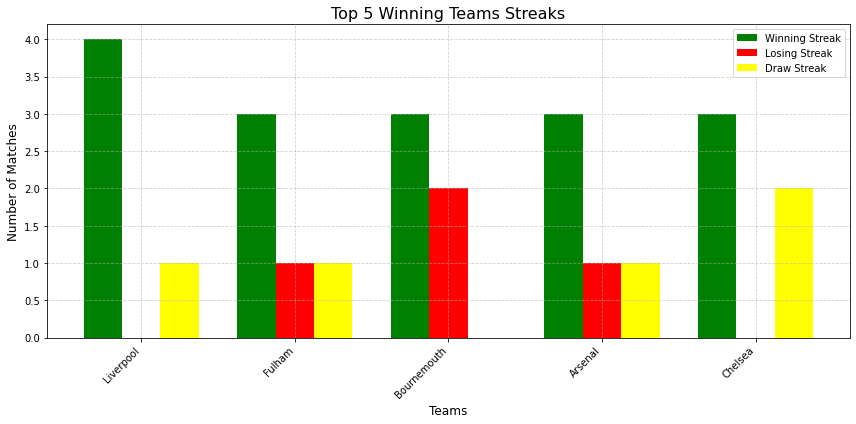

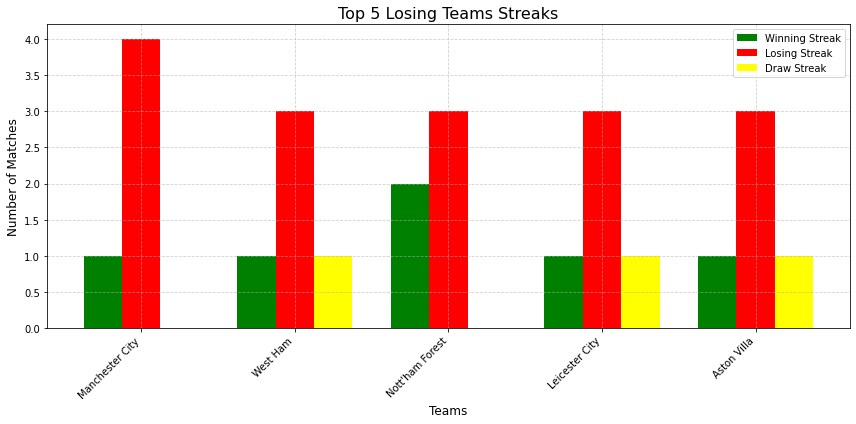

In [8]:
# Aggregation pipeline to calculate streaks for wins, losses, and draws
streaky_pipeline = [
    {
        "$group": {  # Group by team to aggregate data
            "_id": "$team",
            "last_5_matches": {"$first": "$last_5_matches"}
        }
    },
    {
        "$project": {
            "_id": 0,
            "team": "$_id",
            "last_5": {
                "$ifNull": ["$last_5_matches", ""]
            },
            "wins_streak": {
                "$size": {
                    "$filter": {
                        "input": {"$split": ["$last_5_matches", " "]},
                        "as": "result",
                        "cond": {"$eq": ["$$result", "W"]}
                    }
                }
            },
            "losses_streak": {
                "$size": {
                    "$filter": {
                        "input": {"$split": ["$last_5_matches", " "]},
                        "as": "result",
                        "cond": {"$eq": ["$$result", "L"]}
                    }
                }
            },
            "draws_streak": {
                "$size": {
                    "$filter": {
                        "input": {"$split": ["$last_5_matches", " "]},
                        "as": "result",
                        "cond": {"$eq": ["$$result", "D"]}
                    }
                }
            }
        }
    }
]

# Execute pipeline and convert to DataFrame
streaky_results = list(db["matches"].aggregate(streaky_pipeline))
streaky_df = pd.DataFrame(streaky_results)

# Ensure streaky_df is sorted and valid
if not streaky_df.empty:
    # Top 5 Winning Teams
    top_5_wins = streaky_df.sort_values(by="wins_streak", ascending=False).head(5)

    # Visualization for Top 5 Winning Teams
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(top_5_wins["team"]))

    ax.bar(
        index - bar_width,
        top_5_wins["wins_streak"],
        bar_width,
        label="Winning Streak",
        color="green"
    )
    ax.bar(
        index,
        top_5_wins["losses_streak"],
        bar_width,
        label="Losing Streak",
        color="red"
    )
    ax.bar(
        index + bar_width,
        top_5_wins["draws_streak"],
        bar_width,
        label="Draw Streak",
        color="yellow"
    )

    ax.set_xticks(index)
    ax.set_xticklabels(top_5_wins["team"], rotation=45, ha="right")
    ax.set_title("Top 5 Winning Teams Streaks", fontsize=16)
    ax.set_xlabel("Teams", fontsize=12)
    ax.set_ylabel("Number of Matches", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Top 5 Losing Teams
    top_5_losses = streaky_df.sort_values(by="losses_streak", ascending=False).head(5)

    # Visualization for Top 5 Losing Teams
    fig, ax = plt.subplots(figsize=(12, 6))
    index = np.arange(len(top_5_losses["team"]))

    ax.bar(
        index - bar_width,
        top_5_losses["wins_streak"],
        bar_width,
        label="Winning Streak",
        color="green"
    )
    ax.bar(
        index,
        top_5_losses["losses_streak"],
        bar_width,
        label="Losing Streak",
        color="red"
    )
    ax.bar(
        index + bar_width,
        top_5_losses["draws_streak"],
        bar_width,
        label="Draw Streak",
        color="yellow"
    )

    ax.set_xticks(index)
    ax.set_xticklabels(top_5_losses["team"], rotation=45, ha="right")
    ax.set_title("Top 5 Losing Teams Streaks", fontsize=16)
    ax.set_xlabel("Teams", fontsize=12)
    ax.set_ylabel("Number of Matches", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

else:
    print("No data found for streaky performers.")


In [17]:
# Define the aggregation pipeline
pipeline = [
    # Group players by team and push all player data
    {
        "$group": {
            "_id": "$team",
            "players": {
                "$push": {
                    "name": "$player_name",
                    "goals": "$goals",
                    "role": "$role"
                }
            }
        }
    },
    # Lookup team stats for additional data
    {
        "$lookup": {
            "from": "team_stats",
            "localField": "_id",
            "foreignField": "team",
            "as": "team_stats"
        }
    },
    # Lookup match data for last 5 matches
    {
        "$lookup": {
            "from": "matches",
            "localField": "_id",
            "foreignField": "team",
            "as": "match_data"
        }
    },
    # Project relevant fields
    {
        "$project": {
            "team": "$_id",
            "players": 1,
            "top_scorer": {
                "$arrayElemAt": [
                    {
                        "$filter": {
                            "input": "$players",
                            "as": "player",
                            "cond": {
                                "$and": [
                                    {"$eq": ["$$player.name", "Mohamed Salah"]},
                                    {"$eq": ["$$player.role", "Top Scorer"]}
                                ]
                            }
                        }
                    },
                    0
                ]
            },
            "goalkeeper": {"$arrayElemAt": ["$team_stats.goalkeeper", 0]},
            "attendance": {"$arrayElemAt": ["$team_stats.attendance", 0]},
            "last_5_matches": {"$arrayElemAt": ["$match_data.last_5_matches", 0]}
        }
    },
    # Filter teams where Mohamed Salah is the top scorer
    {
        "$match": {
            "top_scorer": {"$ne": None}
        }
    },
    # Add calculated field for Impact Score
    {
        "$addFields": {
            "impact_score": {
                "$multiply": [
                    {"$divide": ["$attendance", 1000]},
                    "$top_scorer.goals"
                ]
            }
        }
    },
    # Final projection for cleaner output
    {
        "$project": {
            "team": 1,
            "top_scorer_name": "$top_scorer.name",
            "top_scorer_goals": "$top_scorer.goals",
            "goalkeeper": 1,
            "attendance": 1,
            "last_5_matches": 1,
            "impact_score": 1
        }
    }
]

# Execute the aggregation query
results = list(db.players.aggregate(pipeline))

# Print the results
if results:
    for result in results:
        print("Team:", result["team"])
        print("Top Scorer:", result["top_scorer_name"])
        print("Goals:", result["top_scorer_goals"])
        print("Goalkeeper:", result["goalkeeper"])
        print("Attendance:", result["attendance"])
        print("Last 5 Matches:", result["last_5_matches"])
        print("Impact Score:", result["impact_score"])
        print("-" * 50)
else:
    print("No data found matching the criteria.")
    
# Insights for Interpretation
print("\nInsights for Interpretation:")
print("Low Impact Scores (<100): Teams with lower attendance or fewer goals from their top scorer.")
print("High Impact Scores (>500): Teams with high fan engagement and strong top scorer performance.")

Team: Liverpool
Top Scorer: Mohamed Salah
Goals: 13
Goalkeeper: Caoimhín Kelleher
Attendance: 60265
Last 5 Matches: W W W W D
Impact Score: 783.445
--------------------------------------------------

Insights for Interpretation:
Low Impact Scores (<100): Teams with lower attendance or fewer goals from their top scorer.
High Impact Scores (>500): Teams with high fan engagement and strong top scorer performance.


In [31]:
# Connect to MongoDB
def connect_to_database():
    print("Connecting to the 'football_data' database...")
    client = MongoClient("mongodb://localhost:27017/")
    return client["football_data"]

# Establish connection
db = connect_to_database()
live_commentary_collection = db.live_commentary
team_players_collection = db.team_players

# Match details
match_details = {
    "match": "Manchester United vs Liverpool",
    "date": "2024-05-12",  # Updated match date
    "time": "18:30",  # Approximate kick-off time
    "stadium": "Old Trafford",
    "competition": "Premier League",
    "teams": ["Manchester United", "Liverpool"]
}

# Ensure players are in the collection
team_players = [
    {"team": "Liverpool", "players": ["Caoimhín Kelleher", "Virgil van Dijk", "Trent Alexander-Arnold", "Mohamed Salah", "Darwin Nunez", "Andrew Robertson"]},
    {"team": "Manchester United", "players": ["David de Gea", "Luke Shaw", "Lisandro Martinez", "Marcus Rashford", "Bruno Fernandes", "Casemiro"]}
]

# Insert team players data if not already present
if team_players_collection.count_documents({}) == 0:
    team_players_collection.insert_many(team_players)
    print("Team players data inserted into the 'team_players' collection.")

# Helper function to get player names dynamically
def get_player_name(team, role):
    players = team_players_collection.find_one({"team": team})
    if players and "players" in players:
        if role == "goalkeeper":
            return players["players"][0]  # Assume first player is goalkeeper
        elif role == "top_scorer":
            return players["players"][3]  # Assume fourth player is top scorer
        elif role == "defender":
            return players["players"][1]  # Assume second player is a defender
        elif role == "midfielder":
            return players["players"][5]  # Assume sixth player is a midfielder
        elif role == "striker":
            return players["players"][4]  # Assume fifth player is a striker
    return "Unknown Player"

# Commentary events
# Note: The match duration has been scaled down from 90 minutes to 300 seconds (5 minutes).
# Each "minute" in the events represents approximately 3.33 seconds in the simulated match.
events = [
    {"minute": 1, "event": "Kick-off! The match between Manchester United and Liverpool begins."},
    {"minute": 4, "event": f"{get_player_name('Liverpool', 'top_scorer')} makes a run down the right flank but is stopped by {get_player_name('Manchester United', 'defender')}."},
    {"minute": 7, "event": f"{get_player_name('Manchester United', 'midfielder')} takes a free kick, but it's cleared by {get_player_name('Liverpool', 'defender')}."},
    {"minute": 12, "event": f"Goal! Liverpool takes the lead. {get_player_name('Liverpool', 'top_scorer')} scores with a clinical finish from {get_player_name('Liverpool', 'defender')}'s cross!"},
    {"minute": 17, "event": f"{get_player_name('Manchester United', 'midfielder')} intercepts a pass and launches a counter-attack for Manchester United."},
    {"minute": 22, "event": f"{get_player_name('Liverpool', 'goalkeeper')} makes a crucial save from a {get_player_name('Manchester United', 'striker')} shot!"},
    {"minute": 28, "event": "Yellow card for Fabinho after a late challenge on {get_player_name('Manchester United', 'striker')}."},
    {"minute": 33, "event": f"Corner for Liverpool. {get_player_name('Liverpool', 'defender')} delivers, but {get_player_name('Manchester United', 'defender')} clears the danger."},
    {"minute": 38, "event": f"Goal! Manchester United equalize. {get_player_name('Manchester United', 'top_scorer')} scores after a brilliant through ball from {get_player_name('Manchester United', 'midfielder')}."},
    {"minute": 41, "event": f"{get_player_name('Manchester United', 'goalkeeper')} denies {get_player_name('Liverpool', 'striker')} with a fantastic reflex save."},
    {"minute": 45, "event": "Half-time: Manchester United 1-1 Liverpool."},
    {"minute": 46, "event": "Second half kicks off. Both teams look determined to secure the win."},
    {"minute": 50, "event": f"{get_player_name('Liverpool', 'defender')}'s cross finds {get_player_name('Liverpool', 'top_scorer')}, but his header goes just wide."},
    {"minute": 55, "event": f"Goal! Liverpool regains the lead. {get_player_name('Liverpool', 'striker')} heads in from a perfect {get_player_name('Liverpool', 'defender')} cross."},
    {"minute": 61, "event": f"Substitution: Manchester United brings on Christian Eriksen for {get_player_name('Manchester United', 'striker')}."},
    {"minute": 65, "event": f"{get_player_name('Liverpool', 'defender')} blocks a powerful shot from {get_player_name('Manchester United', 'midfielder')}."},
    {"minute": 70, "event": "Goal! Manchester United equalizes again. Jadon Sancho scores after a quick counter-attack."},
    {"minute": 74, "event": f"Substitution: Liverpool brings on Diogo Jota for {get_player_name('Liverpool', 'striker')}."},
    {"minute": 78, "event": f"{get_player_name('Manchester United', 'midfielder')} wins the ball in midfield and starts a promising move for United."},
    {"minute": 82, "event": f"Goal! Liverpool takes the lead for the third time. {get_player_name('Liverpool', 'top_scorer')} finishes coolly from a Firmino assist."},
    {"minute": 85, "event": f"{get_player_name('Manchester United', 'defender')} clears a dangerous ball after Jota's effort."},
    {"minute": 88, "event": f"Yellow card for {get_player_name('Liverpool', 'defender')} after a foul on {get_player_name('Manchester United', 'top_scorer')}."},
    {"minute": 90, "event": f"Goal! Liverpool seals the win. Firmino scores after a quick one-two with {get_player_name('Liverpool', 'top_scorer')}."},
    {"minute": 90, "event": "Full-time: Manchester United 2-4 Liverpool. A fantastic performance by Liverpool."}
]

# Simulate real-time commentary
print("Starting live commentary simulation...")
for event in events:
    commentary = {
        "match": match_details["match"],
        "date": match_details["date"],
        "time": match_details["time"],
        "stadium": match_details["stadium"],
        "competition": match_details["competition"],
        "minute": event["minute"],
        "event": event["event"],
        "timestamp": datetime.now()
    }
    live_commentary_collection.insert_one(commentary)
    print(f"Minute {event['minute']}: {event['event']}")
    time.sleep(3.33)  # Simulates approximately 3.33-second intervals to represent scaled-down match duration

print("Live commentary simulation complete.")


Connecting to the 'football_data' database...
Team players data inserted into the 'team_players' collection.
Starting live commentary simulation...
Minute 1: Kick-off! The match between Manchester United and Liverpool begins.
Minute 4: Mohamed Salah makes a run down the right flank but is stopped by Luke Shaw.
Minute 7: Casemiro takes a free kick, but it's cleared by Virgil van Dijk.
Minute 12: Goal! Liverpool takes the lead. Mohamed Salah scores with a clinical finish from Virgil van Dijk's cross!
Minute 17: Casemiro intercepts a pass and launches a counter-attack for Manchester United.
Minute 22: Caoimhín Kelleher makes a crucial save from a Bruno Fernandes shot!
Minute 28: Yellow card for Fabinho after a late challenge on {get_player_name('Manchester United', 'striker')}.
Minute 33: Corner for Liverpool. Virgil van Dijk delivers, but Luke Shaw clears the danger.
Minute 38: Goal! Manchester United equalize. Marcus Rashford scores after a brilliant through ball from Casemiro.
Minute 4